In [2]:
import pandas as pd
import random
import numpy as np
import scipy.stats as stats
from scipy import optimize
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple, Union
from dataclasses import dataclass
from scipy.spatial import distance

In [5]:
result_path = "../data/result1_test.csv"
df = pd.read_csv(result_path, header=None)
df.columns = ['x', 'y', 'z', 'value']
print(df)

        x    y    z        value
0     0.5  0.5  0.0  1531.771118
1     1.5  0.5  0.0  1827.572510
2     2.5  0.5  0.0  1218.727173
3     3.5  0.5  0.0  1015.480652
4     4.5  0.5  0.0   749.622131
..    ...  ...  ...          ...
135   9.5  9.5  0.0    90.363411
136  10.5  9.5  0.0    81.334854
137  11.5  9.5  0.0    68.844215
138  12.5  9.5  0.0    58.700428
139  13.5  9.5  0.0    50.448380

[140 rows x 4 columns]


In [6]:
@dataclass
class Source:
    """
    Create point radiation source.

    Examples
    --------
    >>> Source([1, 2, 3], 2.0)
    Source(loc=[1, 2, 3], intensity=2.0)
    """

    #: Location of the radiation source such that [x, y, z] [m].
    loc: List[float]
    #: Intensity of the radiation source [MBq]. (default is 1.0)
    intensity: float = 1.0

In [7]:
class World(object):
    """
    Create world for adding radiation sources and detectors.
    """
    def __init__(self):
        self.sources: List[Source] = []

    def __repr__(self) -> str:
        repr_str = f"{self.__class__}: contains {len(self.sources)} sources.\n"
        src_str = ",\n ".join([str(it) for it in self.sources])
        repr_str = f"{repr_str}[\n {src_str}\n]"
        return repr_str

    def add_source(self, source: Source):
        """
        Add radiation point source.

        Parameters
        ----------
        source: Source
            Radiation point source.
        """
        self.sources.append(source)

    def visualize_world(
        self,
        figsize: Tuple[float, float] = (8, 8),
        plotsize: float = 10,
    ) -> plt.Axes:
        """
        Visualize radiation sources and detectors in world (X-Y plane).

        Parameters
        ----------
        detectors: List[Detector]
            List of detectors to be visualized. (default is [])
        figsize: tuple(float, float)
            figsize for plot.
        plotsize: float
            Plot in xy plane [-plotsize, plotsize] x [-plotsize, plotsize]

        Returns
        -------
        ax: plt.Axes
            Matplotlib axes
        """

        # Setup plot area
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)
        ax.plot(
            [plotsize, plotsize, -plotsize, -plotsize],
            [plotsize, -plotsize, plotsize, -plotsize],
            "wd",
        )
        ax.plot([0], [0], "rd")
        ax.set_aspect("equal")
        ax.set_title("X (horizontal), Y (vertical), Origin (red dot)")

        # Visualize sources
        x = []
        y = []
        c = []
        for src in self.sources:
            x.append(src.loc[0])
            y.append(src.loc[1])
            c.append(src.intensity)

        sc = ax.scatter(x, y, s=100, c=c, cmap=plt.cm.jet)
        _ = fig.colorbar(sc, orientation="horizontal")

        return ax

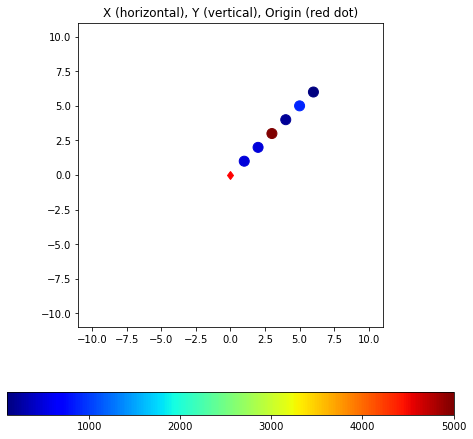

In [8]:
# Construct world
world = World()
world.add_source(Source(loc=np.array([1,1,0]), intensity=500))
world.add_source(Source(loc=np.array([2,2,0]), intensity=500))
world.add_source(Source(loc=np.array([3,3,0]), intensity=5000))
world.add_source(Source(loc=np.array([4,4,0]), intensity=200))
world.add_source(Source(loc=np.array([5,5,0]), intensity=900))
world.add_source(Source(loc=np.array([6,6,0]), intensity=100))

ax = world.visualize_world()

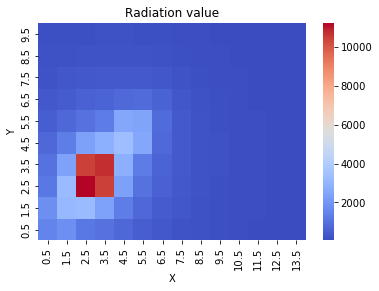

In [9]:
heatmap = df.pivot('y', 'x', 'value')
sns.heatmap(heatmap, cmap='coolwarm')
plt.gca().invert_yaxis() #invert y axis
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Radiation value')
plt.show()
    

In [16]:
df_cnt = df['value']
b_measure = df_cnt
x_b = df[['x', 'y', 'z']]
print(x_b)
assert x_b.shape[0] == len(b_measure), 'Number of measument should be equal to number of position'

        x    y    z
0     0.5  0.5  0.0
1     1.5  0.5  0.0
2     2.5  0.5  0.0
3     3.5  0.5  0.0
4     4.5  0.5  0.0
..    ...  ...  ...
135   9.5  9.5  0.0
136  10.5  9.5  0.0
137  11.5  9.5  0.0
138  12.5  9.5  0.0
139  13.5  9.5  0.0

[140 rows x 3 columns]


In [19]:
def generate_grid(W=10, H=10):
    x_lin = np.linspace(-W, W, 14)
    y_lin = np.linspace(H, -H, 10)
    x_grid, y_grid = np.meshgrid(x_lin, y_lin)
    return x_grid, y_grid

In [25]:
# radiation source candidate
x_q = []
x_grid, y_grid = generate_grid(W=14, H=10)
# radiation source should be z = 0
x_q = np.stack([x_grid, y_grid, np.zeros_like(x_grid)], axis=-1)
x_q = x_q.reshape(-1, 3)

# A matrix in Equation 3
dist = distance.cdist(x_b, x_q)

# TODO: Check again later. Might be wrong
factors = np.stack([10*5 for d in range(len(df_cnt))])[:, np.newaxis]

A = factors/dist**2

## Optimization
### Gradient decent

In [26]:
def score_func(q):
    global A, b_measure
    b_ave = A.dot(q)
    score = np.sum(b_measure*np.log(b_ave))-np.sum(b_ave)
    return score

def grad_func(q):
    global A, b_measure
    b_ave = A.dot(q)
    grad_tmp = (b_measure/b_ave)[:,np.newaxis]*A
    grad = grad_tmp.sum(axis=0) - A.sum(axis=0)
    return grad

In [27]:
# initial guess for radiation distribution
M = x_q.shape[0]
q_max = 10
q_init = 1/q_max
q = np.array([q_init]*M)
# b_ave = A.dot(q)
# plt.imshow(b_ave.reshape(div_num, div_num))

optim_factor = 0.00002
init_score = score_func(q)
print(f'initial score:{init_score}')

initial score:405939.73988493683


/tmp/ipykernel_84700/3282009756.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  grad_tmp = (b_measure/b_ave)[:,np.newaxis]*A


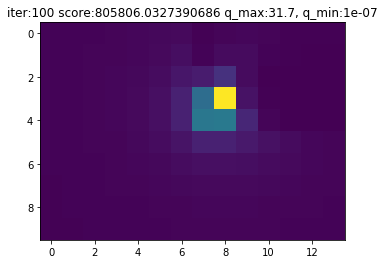

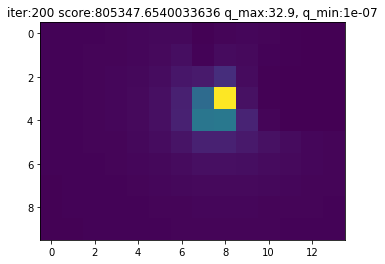

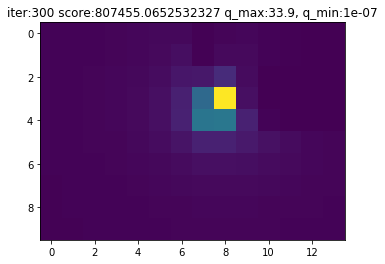

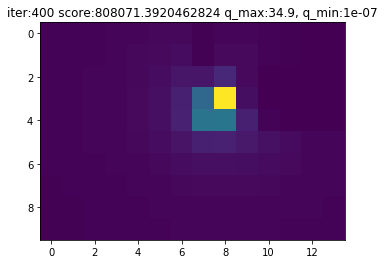

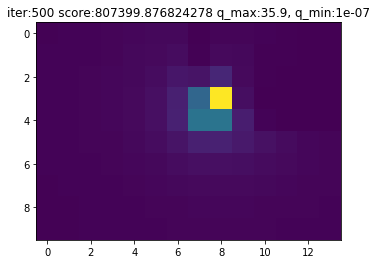

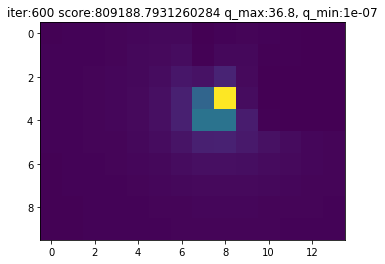

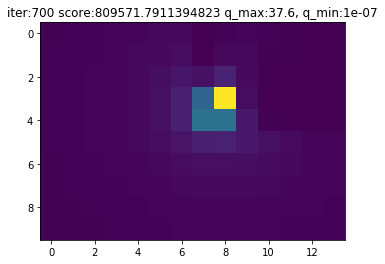

In [31]:
for i in range(1, 800):
    q_diff = grad_func(q)
    q += optim_factor*q_diff

    # bound > 0
    q[q<0]=0.0000001

    score = score_func(q)
    if i%100==0:
        plt.figure()
        plt.title(f'iter:{i} score:{score} q_max:{q.max():.3}, q_min:{q.min():.3}')
        plt.imshow(q.reshape(10, 14))

## SLSQP
Sequential (least-squares) quadratic programming (SQP)

In [32]:
# initial guess for radiation distribution
M = x_q.shape[0]
q_max = 10
q_init = 1/q_max
q = np.array([q_init]*M)

# bound
lb = [0.000000]*M
ub = [np.inf]*M
bounds = optimize.Bounds(lb, ub)

# method
method='SLSQP'
options={'disp': True, 'iprint':2}
# method='L-BFGS-B'
# options={'disp': True, 'iprint':101, 'maxfun': 150000}

# method='trust-constr'
# options={'disp': True, 'verbose':2}

# Formulated as error function
inv_score_fun = lambda x:-score_func(x)
inv_grad_fun = lambda x:-grad_func(x)

In [33]:
# gradient check
for _ in range(3):
    rand_q = np.random.rand(M)
    err = optimize.check_grad(inv_score_fun, inv_grad_fun, rand_q)
    err/=inv_grad_fun(rand_q).mean()
    print(f'Error ratio:{err:.4}')

Error ratio:-4.195e-05
Error ratio:-2.586e-05
Error ratio:-4.958e-05


/tmp/ipykernel_84700/3282009756.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  grad_tmp = (b_measure/b_ave)[:,np.newaxis]*A


In [34]:
res = optimize.minimize(inv_score_fun, q, method=method, bounds=bounds, options=options)
print(res.message)
print(f'Final score:{-res.fun}')

  NIT    FC           OBJFUN            GNORM
    1   142     1.308549E+09     2.736591E+05
    2   293    -6.902315E+05     1.334351E+04
    3   434    -5.996396E+05     5.975821E+03
    4   578    -6.833231E+05     6.059850E+03
    5   720    -6.929164E+05     5.947015E+03
    6   861    -6.966054E+05     5.683215E+03
    7  1002    -7.036068E+05     5.615962E+03
    8  1143    -7.451960E+05     5.307870E+03
    9  1284    -6.169580E+05     3.597205E+03
   10  1426    -4.856996E+05     1.264436E+03
   11  1569    -6.655337E+05     1.016772E+04
   12  1711    -7.417631E+05     1.005927E+04
   13  1853    -7.062763E+05     9.757469E+03
   14  1996    -6.960718E+05     9.664310E+03
   15  2139    -5.689638E+05     9.565582E+03
   16  2283    -6.683902E+05     9.646439E+03
   17  2425    -7.725997E+05     9.510439E+03
   18  2567    -8.044722E+05     9.003031E+03
   19  2709    -8.076862E+05     7.214567E+03
   20  2851    -8.046279E+05     5.406941E+03
   21  2993    -8.045322E+05     4

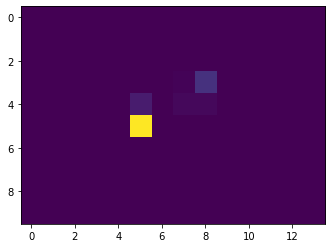

In [35]:
plt.imshow(res.x.reshape(10, 14))

high intensity location:
 [[ 3.23076923  3.33333333  0.        ]
 [-3.23076923 -1.11111111  0.        ]]
Source(loc=array([1, 1, 0]), intensity=500)
Source(loc=array([2, 2, 0]), intensity=500)
Source(loc=array([3, 3, 0]), intensity=5000)
Source(loc=array([4, 4, 0]), intensity=200)
Source(loc=array([5, 5, 0]), intensity=900)
Source(loc=array([6, 6, 0]), intensity=100)


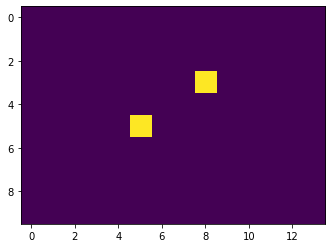

In [37]:
thresh = res.x.max()/10
idx = np.where(res.x>thresh)
print(f'high intensity location:\n {x_q[idx[0]]}')
plt.imshow((res.x>thresh).reshape(10, 14))
for it in world.sources:
    print(it)